In [1]:
from datetime import datetime
import gsw
import matplotlib.pyplot as plt
import pandas as pd
from onc import ONC

# Import common code from the python-community-notebooks repository.
from pcn_common import get_onc_token_from_netrc,format_datetime, convert_scalar_data, identify_profiles

In [2]:
token = get_onc_token_from_netrc(machine = 'data.oceannetworks.ca')
onc = ONC(token = token)

In [3]:
date_from = datetime(2025,6,14,22,0,0,0)
date_to = datetime(2025,6,15,23,59,59,999999)

In [4]:
params = {'locationCode': 'BACVP',
          'deviceCategoryCode': 'DC90',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False,
          'propertyCode': 'length'}
json_response = onc.getScalardata(filters = params, allPages=True)
cl = convert_scalar_data(json_response_data=json_response, out_as = 'xarray')
cable_length = cl.cable_length
cable_length = cable_length.dropna(dim = 'time')

In [5]:
ups = identify_profiles(cable_length, profile_direction='up', max_allowed_std=0.05)
ups = [up for up in ups if (up['dateTo'] - up['dateFrom']).total_seconds() > 60*3] # Keep only profiles longer than 3 minutes.

In [6]:
params = {'locationCode': 'BACVP',
          'deviceCategoryCode': 'CTD',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False}
json_response = onc.getScalardata(filters = params, allPages=True)
ctd = convert_scalar_data(json_response_data=json_response, out_as = 'xarray')

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 4 pages in total.
Estimated approx. 29 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (299999 samples) Downloading page 4...
   (363276 samples) Completed in 35 seconds.


In [7]:
lat = 48.427455
lon = -126.174124

In [8]:
profiles = []
for up in ups:
    ctd_pro = ctd.sel(time = slice(up['dateFrom'],up['dateTo']))

    ctd_pro = ctd_pro.sortby('time')
    ctd_pro = ctd_pro.dropna(dim = 'time', how = 'all')
    ctd_pro = ctd_pro.assign_coords({'profile_id': [pd.to_datetime(ctd_pro.time.min().values).strftime('%Y%m%dT%H%M%SZ')]})
    ctd_pro = ctd_pro.rolling({'time': 5}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.

    # Convert cond from S/m to mS/cm for GSW.
    ctd_pro['conductivity'] = ctd_pro['conductivity'] * 10
    ctd_pro['conductivity'].attrs['uom'] = 'mS/cm'
    ctd_pro['conductivity'].attrs['unitOfMeasure'] = 'mS/cm'

    ctd_pro['practical_salinity'] = gsw.SP_from_C(ctd_pro.conductivity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['absolute_salinity'] = gsw.SA_from_SP(ctd_pro.practical_salinity, ctd_pro.temperature,
                                                            lon =  lon, lat =  lat)
    ctd_pro['conservative_temperature'] = gsw.CT_from_t(ctd_pro.absolute_salinity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['density'] = gsw.density.rho(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature, ctd_pro.pressure)
    ctd_pro['potential_density'] = gsw.sigma0(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature)
    ctd_pro['depth'] = gsw.z_from_p(ctd_pro.pressure, lat)*-1

    profiles.append(ctd_pro)

Text(0.5, 0, 'Sea Water Potential Density ($\\frac{kg}{m^3}$)')

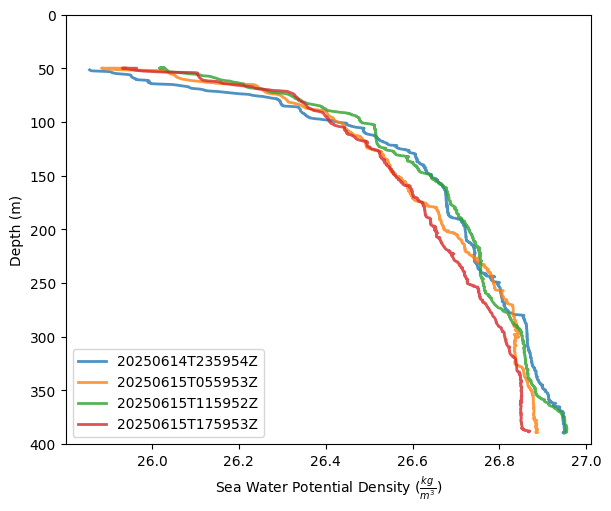

In [9]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

for i in range(len(profiles)):
    pro = profiles[i]
    ax.plot(pro.potential_density, pro.depth, alpha = 0.8, label = pro.profile_id.values, linewidth = 2)

ax.legend(loc = 'lower left')

ax.set_ylim(0,400)

ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Sea Water Potential Density ($\frac{kg}{m^3}$)')
